# Feature Engineering


**İş Problemi**
> Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin
edebilecek bir makine öğrenmesi modeli geliştirilmesi istenmektedir. Modeli
geliştirmeden önce gerekli olan veri analizi ve özellik mühendisliği adımlarını
gerçekleştirmeniz beklenmektedir.

**Veri Seti Hikayesi**
Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır. ABD'deki
Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan **Pima Indian kadınları** üzerinde
yapılan diyabet araştırması için kullanılan verilerdir.
Hedef değişken **"outcome"** olarak belirtilmiş olup; **1** diyabet test sonucunun **pozitif** oluşunu, **0** ise **negatif** oluşunu belirtmektedir.
<table>
    <tr><td> Pregnancies <td><td> Hamilelik sayısı <td></tr>
    <tr><td> Glucose <td><td> Oral glikoz tolerans testinde 2 saatlik plazma glikoz konsantrasyonu <td></tr>
    <tr><td> Blood Pressure <td><td> Kan Basıncı (Küçük tansiyon) (mm Hg) <td></tr>
    <tr><td> SkinThickness <td><td> Cilt Kalınlığı <td></tr>
    <tr><td> Insulin <td><td> 2 saatlik serum insülini (mu U/ml) <td></tr>
    <tr><td> DiabetesPedigreeFunction <td><td> Fonksiyon (Oral glikoz tolerans testinde 2 saatlik plazma glikoz konsantrasyonu) <td></tr>
    <tr><td> BMI <td><td> Vücut kitle endeksi <td></tr>
    <tr><td> Age <td><td> Yaş (yıl) <td></tr>
    <tr><td> Outcome <td><td> Hastalığa sahip (1) ya da değil (0) <td></tr>
</table>

In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from termcolor import colored
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

def missing_values_analysis(data):
    na_columns = [col for col in data.columns if data[col].isnull().sum() > 0]
    n_miss = data[na_columns].isnull().sum().sort_values(ascending=True)
    ratio = (data[na_columns].isnull().sum() / data.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_df(data, row_num=5, col_num=10):
    print("*************** Dataset Shape ***************")
    print("No. of Rows:", data.shape[0], "\nNo. of Columns:", data.shape[1])
    print("*************** Dataset Information ***************")
    print(data.info())
    print("*************** Types of Columns ***************")
    print(data.dtypes)
    print(f"*************** First {row_num} Rows ***************")
    print(data.iloc[:row_num,:col_num])
    print(f"*************** Last {row_num} Rows ***************")
    print(data.iloc[-row_num:,:col_num])
    print("*************** Summary Statistics of The Dataset ***************")
    print(data.describe([0.10, 0.25, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99]).T)
    print("*************** Dataset Missing Values Analysis ***************")
    print(missing_values_analysis(data))


In [129]:
def load():
    data = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")
    return data

df = load()


# Proje Görevleri

# Görev 1 : Keşifçi Veri Analizi

**Adım 1: Genel resmi inceleyiniz.**

In [130]:
check_df(df)

*************** Dataset Shape ***************
No. of Rows: 768 
No. of Columns: 9
*************** Dataset Information ***************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
*************** Types of Columns ***************
Pregnancies                   int64
Glucose         

**Adım 2: Numerik ve kategorik değişkenleri yakalayınız.**

In [131]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [132]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [133]:
print(f"The numerical columns are : {num_cols}")
print(f"The categorical columns are : {cat_cols}")

The numerical columns are : ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
The categorical columns are : ['Outcome']


**Adım 3: Numerik ve kategorik değişkenlerin analizini yapınız.**

In [134]:
def cat_summary(dataframe, cat_cols, plot=False):
    for col_name in cat_cols:
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")
        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)

cat_summary(df,cat_cols) 

         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################


                           count    mean     std    min     5%    10%    20%     30%     40%     50%     60%     70%     80%     90%     95%     99%     max
Pregnancies              768.000   3.845   3.370  0.000  0.000  0.000  1.000   1.000   2.000   3.000   4.000   5.000   7.000   9.000  10.000  13.000  17.000
Glucose                  768.000 120.895  31.973  0.000 79.000 85.000 95.000 102.000 109.000 117.000 125.000 134.000 147.000 167.000 181.000 196.000 199.000
BloodPressure            768.000  69.105  19.356  0.000 38.700 54.000 60.000  64.000  68.000  72.000  74.000  78.000  82.000  88.000  90.000 106.000 122.000
SkinThickness            768.000  20.536  15.952  0.000  0.000  0.000  0.000   8.200  18.000  23.000  27.000  31.000  35.000  40.000  44.000  51.330  99.000
Insulin                  768.000  79.799 115.244  0.000  0.000  0.000  0.000   0.000   0.000  30.500  72.200 106.000 150.000 210.000 293.000 519.900 846.000
BMI                      768.000  31.993   7.884  0.000 21

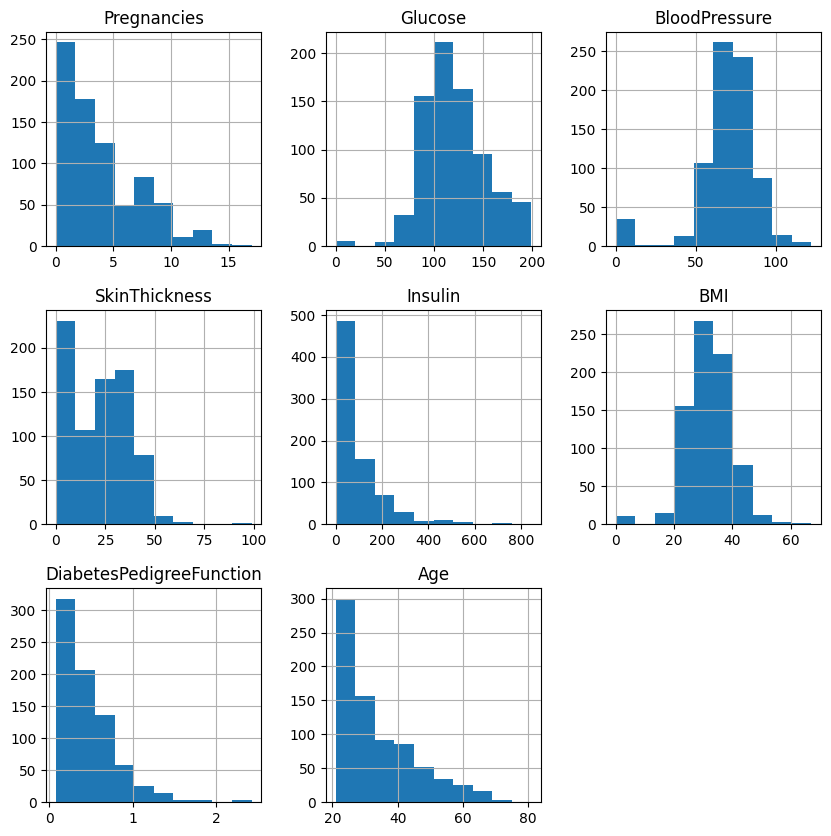

In [135]:
def num_summary(dataframe, numerical_cols, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]    
    print(dataframe[numerical_cols].describe(quantiles).T)

    if plot:
        dataframe[numerical_cols].hist(figsize = (10,10))
        
num_summary(df, num_cols, True)

**Adım 4: Hedef değişken analizi yapınız. (Kategorik değişkenlere göre hedef değişkenin ortalaması, hedef değişkene göre numerik değişkenlerin ortalaması)**

In [136]:
def target_summary_with_num(dataframe, target, numerical_cols):
    for num_col in numerical_cols:
        print(dataframe.groupby(target).agg({num_col: "mean"}), end="\n\n\n")


target_summary_with_num(df, "Outcome", num_cols)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




**Adım 6: Eksik gözlem analizi yapınız**

In [137]:
zero_cols = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

In [138]:
def zero_values_table(dataframe, zero_name=False):
    
    n_zeros = (dataframe[zero_cols] == 0).sum()
    ratio = ((dataframe[zero_cols] == 0).sum() / dataframe.shape[0] * 100)
    zeros_df = pd.concat([n_zeros, np.round(ratio, 2)], axis=1, keys=["n_zeros", "ratio"])
    print(zeros_df, end="\n")

    if zero_name:
        return zero_cols

zero_values_table(df)

               n_zeros  ratio
Glucose              5  0.650
BloodPressure       35  4.560
SkinThickness      227 29.560
Insulin            374 48.700
BMI                 11  1.430


In [85]:
df[zero_cols] = df[zero_cols].replace({0:np.NaN})

In [139]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df, end="\n")
    if na_name:
        return na_columns
na_columns = missing_values_table(df, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [140]:
from sklearn.impute import SimpleImputer
impute=SimpleImputer(missing_values=np.NaN, strategy='mean')

In [141]:
df.iloc[:,:-1]=impute.fit_transform(df.iloc[:,:-1])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [142]:
na_columns = missing_values_table(df, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


**Adım 5: Aykırı gözlem analizi yapınız**

In [143]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def remove_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)    
    rows_to_drop = dataframe[((dataframe[variable] < low_limit) | (dataframe[variable] > up_limit))].index
    dataframe.drop(rows_to_drop, axis=0, inplace=True)



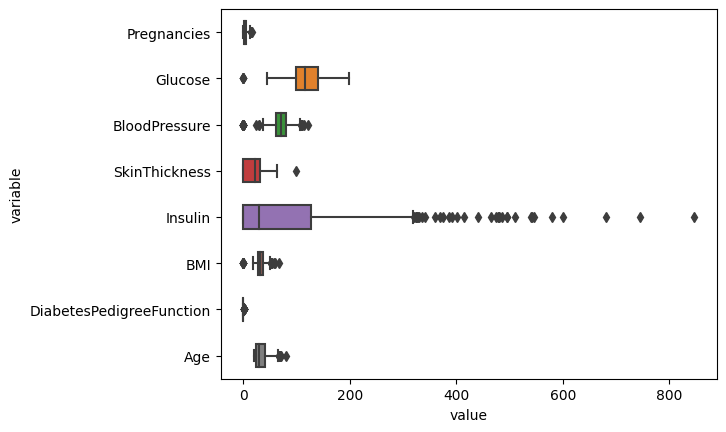

In [144]:
sns.boxplot(data=pd.melt(df[num_cols]), x="value", y="variable", width=0.5)
plt.show()

In [145]:
# Aykırı Değer Analizi ve Baskılama İşlemi
for col in df.columns[:-1]:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        remove_with_thresholds(df, col)

for col in df.columns[:-1]:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


**Adım 7: Korelasyon analizi yapınız**

In [146]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.133,0.141,-0.082,-0.070,0.017,-0.035,0.549,0.224
Glucose,0.133,1.000,0.155,0.054,0.313,0.221,0.124,0.261,0.469
BloodPressure,0.141,0.155,1.000,0.208,0.098,0.282,0.042,0.242,0.066
SkinThickness,-0.082,0.054,0.208,1.000,0.451,0.392,0.179,-0.115,0.076
Insulin,-0.070,0.313,0.098,0.451,1.000,0.206,0.156,-0.063,0.131
BMI,0.017,0.221,0.282,0.392,0.206,1.000,0.139,0.037,0.294
DiabetesPedigreeFunction,-0.035,0.124,0.042,0.179,0.156,0.139,1.000,0.036,0.184
Age,0.549,0.261,0.242,-0.115,-0.063,0.037,0.036,1.000,0.235
Outcome,0.224,0.469,0.066,0.076,0.131,0.294,0.184,0.235,1.000


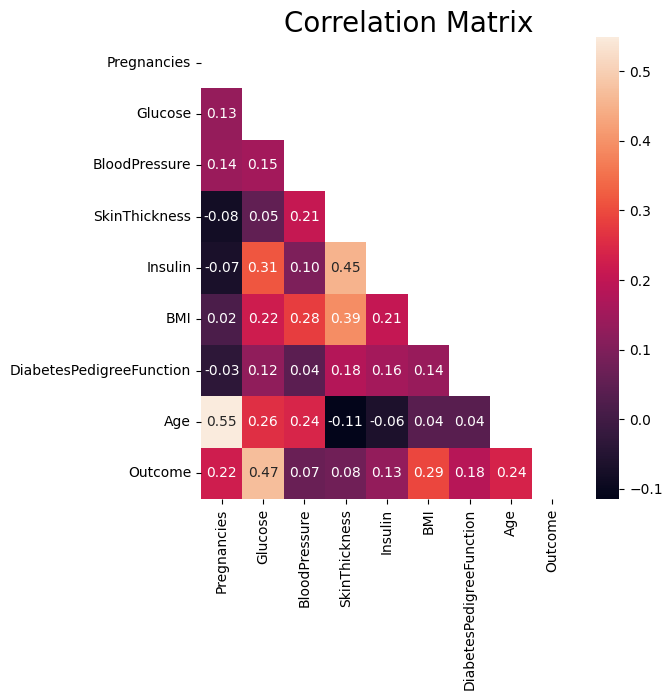

In [147]:
fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(1,1)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])

df_corr = df.corr().transpose()
mask = np.triu(np.ones_like(df_corr))
ax0.text(2,-0.1,"Correlation Matrix",fontsize=20, fontfamily="arial", color="#000000")
sns.heatmap(df_corr,mask=mask,fmt=".2f",annot=True)
plt.show()

In [150]:
# Base Model Kurulumu
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")
print(f"Score: {round(rf_model.score(X_test,y_test), 2)}")

Accuracy: 0.77
Recall: 0.6
Precision: 0.56
F1: 0.58
Auc: 0.72
Score: 0.77


In [155]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

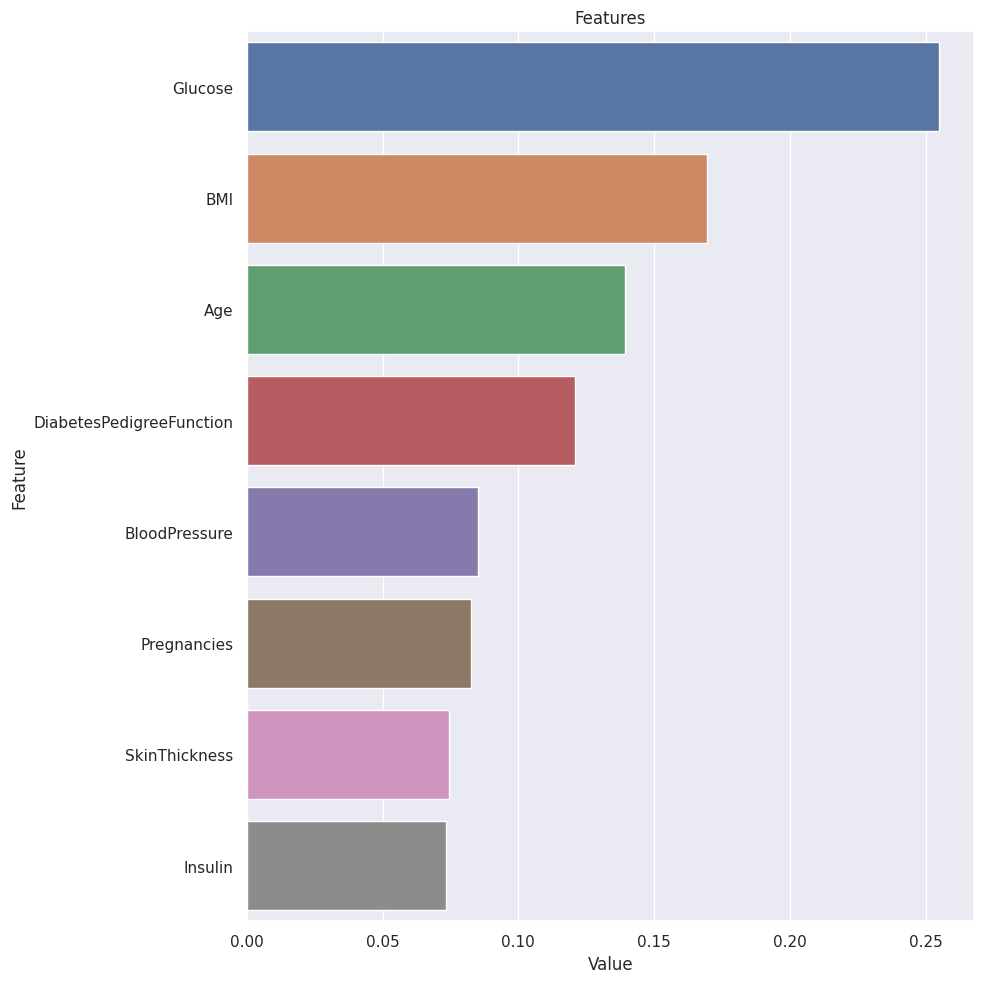

In [156]:
plot_importance(rf_model, X)

# GÖREV 2: Feature Engineering

**Adım 1: Eksik ve aykırı değerler için gerekli işlemleri yapınız. Veri setinde eksik gözlem bulunmamakta ama Glikoz, Insulin vb. değişkenlerde 0 değeri içeren gözlem birimleri eksik değeri ifade ediyor olabilir.** 
> Örneğin; bir kişinin glikoz veya insulin değeri 0 olamayacaktır. Bu durumu dikkate alarak sıfır değerlerini ilgili değerlerde NaN olarak atama yapıp sonrasında eksik değerlere işlemleri uygulayabilirsiniz.

In [151]:
df = load()
cat_cols, num_cols, cat_but_car = grab_col_names(df)
zero_cols = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [152]:
df[zero_cols] = df[zero_cols].replace({0:np.NaN})

In [153]:
impute=SimpleImputer(missing_values=np.NaN, strategy='mean')
df.iloc[:,:-1]=impute.fit_transform(df.iloc[:,:-1])

In [154]:
for col in df.columns[:-1]:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        remove_with_thresholds(df, col)

for col in df.columns[:-1]:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


**Adım 2: Yeni değişkenler oluşturunuz**

In [157]:
# Yaş değişkenini kategorilere ayırıp yeni yaş değişkeni oluşturulması
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT
0,6,148.000,72.000,35.000,155.548,33.600,0.627,50,1,senior
1,1,85.000,66.000,29.000,155.548,26.600,0.351,31,0,mature
2,8,183.000,64.000,29.153,155.548,23.300,0.672,32,1,mature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature


In [158]:
# BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight", "Healthy", "Overweight", "Obese"])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI
0,6,148.000,72.000,35.000,155.548,33.600,0.627,50,1,senior,Obese
1,1,85.000,66.000,29.000,155.548,26.600,0.351,31,0,mature,Overweight
2,8,183.000,64.000,29.153,155.548,23.300,0.672,32,1,mature,Healthy
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese


In [159]:
# Glukoz degerini kategorik değişkene çevirme
df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

In [160]:
# Yaş ve beden kitle indeksini bir arada düşünerek kategorik değişken oluşturma 3 kırılım yakalandı
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"
df.loc[(df["BMI"] > 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"

In [161]:
# Yaş ve Glikoz değerlerini bir arada düşünerek kategorik değişken oluşturma
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM
0,6,148.000,72.000,35.000,155.548,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior
1,1,85.000,66.000,29.000,155.548,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature
2,8,183.000,64.000,29.153,155.548,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature


In [162]:
# İnsulin Değeri ile Kategorik değişken türetmek
def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"

df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)

In [163]:
df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]

In [164]:
df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]

In [165]:
# Kolonların büyültülmesi
df.columns = [col.upper() for col in df.columns]
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,155.548,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,23021.137,888.000
1,1,85.000,66.000,29.000,155.548,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal,13221.599,85.000
2,8,183.000,64.000,29.153,155.548,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal,28465.325,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature,Abnormal,23016.000,0.000


**Adım 3: Encoding işlemlerini gerçekleştiriniz**

In [168]:
# Değişkenlerin tiplerine göre ayrılması işlemi
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 764
Variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_cat: 3


In [169]:
# LABEL ENCODING
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [170]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['NEW_AGE_CAT', 'NEW_INSULIN_SCORE']

In [171]:
for col in binary_cols:
    df = label_encoder(df, col)

In [172]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,155.548,33.600,0.627,50,1,1,Obese,Prediabetes,obesesenior,highsenior,1,23021.137,888.000
1,1,85.000,66.000,29.000,155.548,26.600,0.351,31,0,0,Overweight,Normal,obesemature,normalmature,1,13221.599,85.000
2,8,183.000,64.000,29.153,155.548,23.300,0.672,32,1,0,Healthy,Prediabetes,obesemature,highmature,1,28465.325,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,Overweight,Normal,obesemature,normalmature,1,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,Obese,Normal,obesemature,highmature,0,23016.000,0.000


In [173]:
# One-Hot Encoding İşlemi
# cat_cols listesinin güncelleme işlemi
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
cat_cols

['NEW_AGE_BMI_NOM', 'NEW_AGE_GLUCOSE_NOM', 'NEW_BMI', 'NEW_GLUCOSE']

In [174]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [175]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [176]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,6,148.000,72.000,35.000,155.548,33.600,0.627,50,1,1,1,23021.137,888.000,True,False,False,False,True,False,False,False,False,False,False,True,True,False
1,1,85.000,66.000,29.000,155.548,26.600,0.351,31,0,0,1,13221.599,85.000,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,8,183.000,64.000,29.153,155.548,23.300,0.672,32,1,0,1,28465.325,1464.000,False,False,False,True,False,False,False,False,False,True,False,False,True,False
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,1,8366.000,89.000,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,0,23016.000,0.000,False,False,False,True,False,False,False,False,False,False,False,True,False,False


**Adım 4: Numerik değişkenler için standartlaştırma yapınız**

In [177]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE',
 'NEW_GLUCOSE*INSULIN',
 'NEW_GLUCOSE*PREGNANCIES']

In [178]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [179]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,0.636,0.885,-0.033,0.706,0.031,0.171,0.485,1.438,1,1,1,0.260,0.879,True,False,False,False,True,False,False,False,False,False,False,True,True,False
1,-0.847,-1.207,-0.530,-0.006,0.031,-0.851,-0.364,-0.187,0,0,1,-0.470,-0.858,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,1.229,2.048,-0.695,0.012,0.031,-1.333,0.623,-0.101,1,0,1,0.665,2.125,False,False,False,True,False,False,False,False,False,True,False,False,True,False
3,-0.847,-1.074,-0.530,-0.718,-0.776,-0.632,-0.930,-1.042,0,0,1,-0.831,-0.850,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,-1.144,0.520,-2.679,0.706,0.194,1.559,5.594,-0.016,1,0,0,0.260,-1.042,False,False,False,True,False,False,False,False,False,False,False,True,False,False


In [180]:
X = df.drop("OUTCOME", axis=1)
y = df["OUTCOME"]

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [182]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)

In [183]:
y_pred = rf_model.predict(X_test)

In [184]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 3)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
print(f"F1: {round(f1_score(y_pred, y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy: 0.79
Recall: 0.631
Precision: 0.62
F1: 0.63
Auc: 0.74


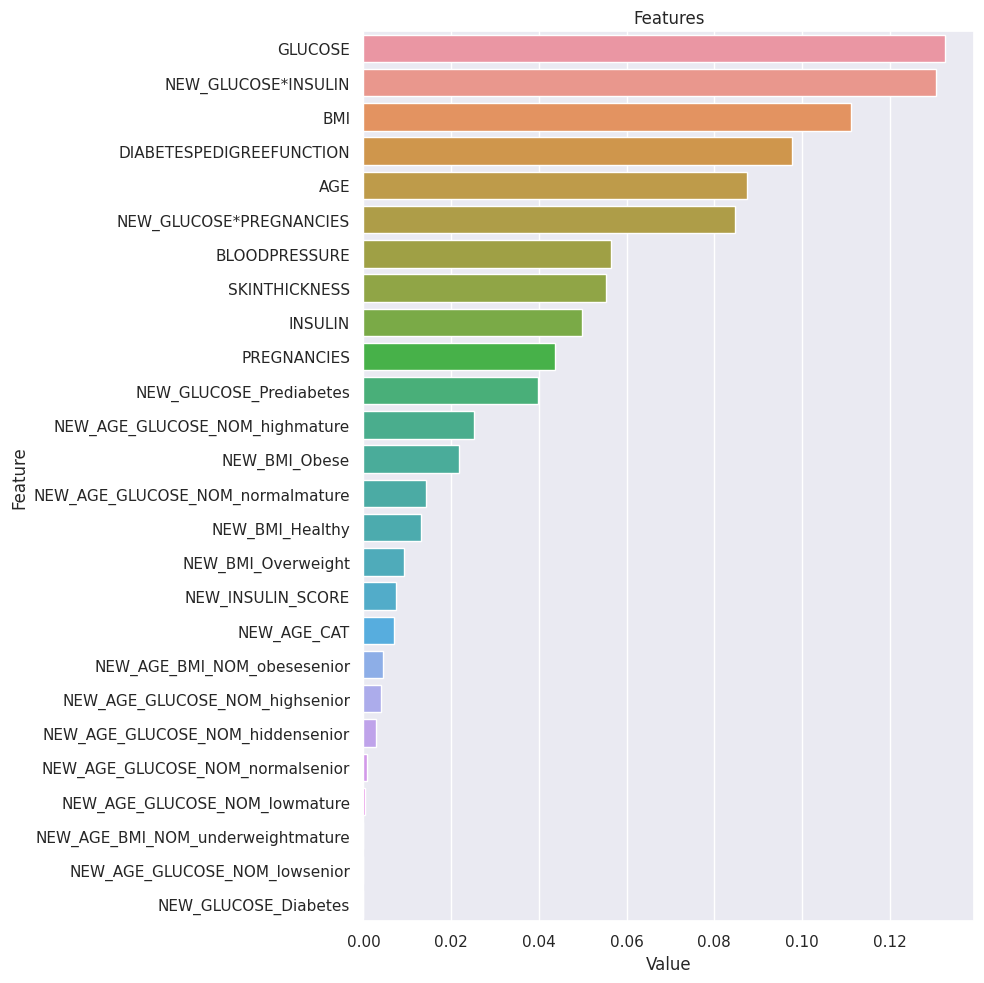

In [185]:
plot_importance(rf_model, X)